# Exámen Final<a class="tocSkip">
## TRATAMIENTO DE SEÑALES <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
**joseiglesias@unicesar.edu.co**

In [9]:
#%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.image as mpimg
import os
import scipy.misc as sm
import skimage


## Desripción del Problema

#### Cargando Imagenes de entrada

La imagen de entrada es el conjunto de 3 fotos, correspondientes a los canales B, G, y R de arriba ahacia abajo. Deberías implementar la función $\tt{load}$\_$\tt{data}$ que lee los datos y devuelve la lista de imágenes.
$\tt{dir}$\_$\tt{name}$ es la ruta al directorio con las imágenes. Si este directorio está ubicado en el mismo directorio que este cuaderno, se pueden usar los argumentos predeterminados.

In [7]:
def load_data(dir_name = 'faces_imgs'):    
    '''
    Cargar imágenes desde el directorio "faces_imgs"
    Las imágenes están en JPG y las convertimos a imágenes en escala de grises.
    '''
    imgs = []
    for filename in os.listdir(dir_name):
        if os.path.isfile(dir_name + '/' + filename):
           img = mpimg.imread(dir_name + '/' + filename)
        #img = skimage.color.rgb2gray(img)
           imgs.append(img)
    return imgs
    
    
plates = load_data()

El conjunto de datos es una lista de matrices bidimensionales.

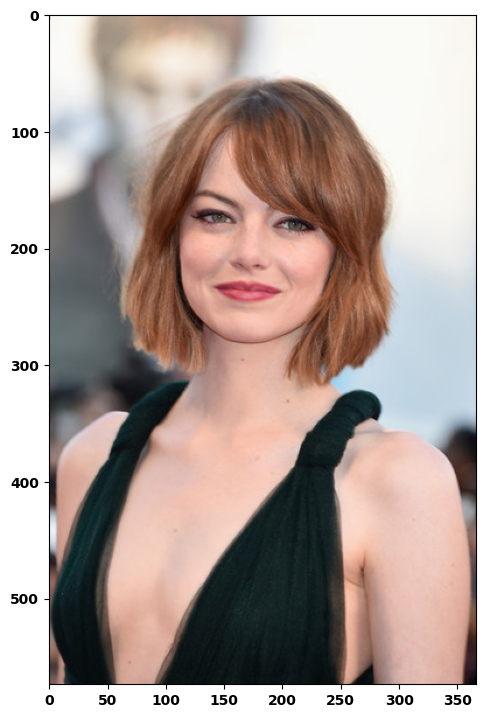

In [10]:
# La función auxiliar `visualize()` muestra las imágenes dadas como argumento.
def visualize(imgs, format=None):
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(4, 2, plt_idx)    
        plt.imshow(img, cmap=cm.gray, vmin=0, vmax=255)
    plt.show()

visualize(plates[1:4:2])

#### La eliminación de bordes (1.5 puntos)
Vale la pena señalar que hay un encuadre de todos los lados en la mayoría de las imágenes. Este encuadre puede empeorar apreciablemente la calidad de la alineación de los canales. Aquí, le sugerimos que encuentre los bordes de las imágenes utilizando el detector de bordes Canny y recorte las imágenes de acuerdo con estos bordes. El ejemplo del uso del detector Canny implementado en la biblioteca skimage se puede encontrar [here](http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html).<br>

Los bordes se pueden eliminar de la siguiente manera:
* Aplique el detector de bordes Canny a la imagen.
* Encuentra las filas y columnas de los píxeles del marco.
Por ejemplo, en el caso del límite superior, buscaremos la fila en la vecindad del borde superior de la imagen (por ejemplo, el 5% de su altura). Para cada fila, contemos el número de píxeles de borde (obtenidos con el detector Canny) que contiene. Teniendo estos números, encontremos dos máximos entre ellos. Dos filas correspondientes a estos máximos son filas de borde. Como hay dos cambios de color en el cuadro (primero, del fondo claro del escáner a la cinta oscura y luego de la cinta a la imagen), necesitamos el segundo máximo que está más alejado del borde de la imagen. La fila correspondiente a este máximo es el borde de recorte. Para no encontrar dos picos vecinos, se debe implementar la supresión no máxima: las filas al lado del primer máximo se establecen en cero, y luego se busca el segundo máximo.

#### Implementación del detector de Canny (2.5 points)
Puede escribir su propia implementación del detector de bordes Canny para obtener puntos extra. <br>

Algoritmo de detección de Canny:
1. *Reducción de ruido.* Para eliminar el ruido, la imagen se suaviza con el desenfoque gaussiano con el kernel de tamaño $5 \times 5$ y $\sigma = 1.4$. Dado que la suma de los elementos en el núcleo gaussiano es igual $1$, el kernel debe normalizarse antes de la convolución. <br><br>

2. *Cálculo de gradientes.* Cuando la imagen $I$ Se suaviza, las derivadas $I_x$ y $I_y$ w.r.t. $x$ y $y$ son calculadas. Se puede implementar convolucionando $I$ con núcleos Sobel $K_x$ and $K_y$, respectivamente:
$$ K_x = \begin{pmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{pmatrix}, K_y = \begin{pmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{pmatrix}. $$ 
Entonces, la magnitud $G$ y la pendiente $\theta$ del gradiente se calculan:
$$ |G| = \sqrt{I_x^2 + I_y^2}, $$
$$ \theta(x,y) = arctan\left(\frac{I_y}{I_x}\right)$$<br><br>

3. *Supresión no máxima.* Para cada píxel, busque dos vecinos (en las direcciones de gradiente positivo y negativo, suponiendo que cada vecino ocupa el ángulo de $\pi /4$, y $0$ es la dirección recta a la derecha). Si la magnitud del píxel actual es mayor que las magnitudes de los vecinos, nada cambia, de lo contrario, la magnitud del píxel actual se establece en cero.<br><br>

4. *Umbral doble.* Las magnitudes de gradiente se comparan con dos valores de umbral especificados, el primero es menor que el segundo. Los gradientes que son más pequeños que el valor de umbral bajo se suprimen; los gradientes superiores al valor de umbral alto se marcan como fuertes y los píxeles correspondientes se incluyen en el mapa de borde final. Todos los demás gradientes se marcan como débiles y los píxeles correspondientes a estos gradientes se consideran en el siguiente paso.<br><br>

5. *Seguimiento de borde por histéresis.* Dado que un píxel de borde débil causado por bordes verdaderos se conectará a un píxel de borde fuerte, el píxel $w$ con un degradado débil se marca como borde y se incluye en el mapa de borde final si y solo si está involucrado en el mismo blob (componente conectado) que algún píxel $s$ con fuerte pendiente. En otras palabras, debe haber una cadena de píxeles vecinos débiles que se conecten $w$ y $s$ (los vecinos son 8 píxeles alrededor del considerado). Le invitamos a inventar e implementar un algoritmo que encuentre todos los componentes conectados del mapa de degradado considerando cada píxel solo una vez. Después de eso, puede decidir qué píxeles se incluirán en el mapa de borde final (este algoritmo también debe ser de un solo paso).

In [11]:
from scipy import ndimage

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)
    

def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    #pi_4 = np.pi / 4
    #pi_2 = np.pi / 2
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                #theta = D[i,j] #* 180 / np.pi #angle in degrees
                #theta_mod = theta % np.pi
                q = 255
                r = 255
                #alpha = None
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                """
                if (0 <= theta_mod < pi_4):
                    alpha = np.abs(np.tan(theta_mod))
                    q = (alpha * img[i + 1, j + 1]) + ((1 - alpha) * img[i, j + 1])
                    r = (alpha * img[i - 1, j - 1]) + ((1 - alpha) * img[i, j - 1]) 
                    
                elif (pi_4 <= theta_mod < pi_2):
                    alpha = np.abs(1./np.tan(theta_mod))
                    q = (alpha * img[i + 1, j + 1]) + ((1 - alpha) * img[i + 1, j])
                    r = (alpha * img[i - 1, j - 1]) + ((1 - alpha) * img[i - 1, j])
                    
                elif (pi_2 <= theta_mod < (3*pi_4)):
                    alpha = np.abs(1./np.tan(theta_mod))
                    q = (alpha * img[i + 1, j - 1]) + ((1 - alpha) * img[i + 1, j])
                    r = (alpha * img[i - 1, j + 1]) + ((1 - alpha) * img[i - 1, j])
                
                elif ((3*pi_4) <= theta_mod < np.pi):
                    alpha = np.abs(np.tan(theta_mod))
                    q = (alpha * img[i + 1, j - 1]) + ((1 - alpha) * img[i, j - 1])
                    r = (alpha * img[i - 1, j + 1]) + ((1 - alpha) * img[i, j + 1])
                """
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
                

            except IndexError as e:
                pass
    
    return Z

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

def hysteresis(img, weak, strong=255):
    
    M, N = img.shape  
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    
    return img

In [12]:
#################################################################
# TODO: implemente el detector Canny usted mismo. #
# Puede usar métodos de scipy.ndimage si lo necesita.     #
#################################################################

    
    

In [ ]:
#################################################################
# TODO: implementar la eliminación de los bordes de la cinta usando #
# la salida del detector de bordes Canny (lista "canny_img")    #
#################################################################


    
    

#### Separación de Canales  (0.5 points)

El siguiente paso es separar la imagen en tres canales (B, G, R) y hacer una imagen en color. Para obtener canales, puede dividir cada placa en tres partes iguales.

In [ ]:
#################################################################
# TODO: implementar la función transform_components transformando #
# imágenes recortadas en blanco y negro cropped_imgs #
# en la lista de imágenes RGB rgb_imgs                   #
#################################################################

    




#### Busque el mejor cambio para la alineación del canal (1 punto para la implementación de métricas + 2 puntos para la alineación del canal)

Para alinear dos imágenes, cambiaremos una imagen con respecto a otra dentro de algunos límites (por ejemplo, de $-15$ to $15$ pixeles). Para cada turno, podemos calcular algunas métricas en la superposición de las imágenes. Según las métricas, el mejor cambio es aquel para el que las métricas logran el mayor o el menor valor. Le sugerimos que implemente dos métricas y elija la que le permita obtener la mejor calidad de alineación:

* *Error medio cuadrado (MSE):*<br><br>
$$ MSE(I_1, I_2) = \dfrac{1}{w * h}\sum_{x,y}(I_1(x,y)-I_2(x,y))^2, $$<br> donde *w, h* son ancho y alto de las imágenes, respectivamente. Para encontrar el cambio óptimo, debe encontrar el MSE mínimo sobre todos los valores de cambio.
    <br><br>
* *Correlación cruzada normalizada (CC):*<br><br>
    $$
    I_1 \ast I_2 = \dfrac{\sum_{x,y}I_1(x,y)I_2(x,y)}{\sum_{x,y}I_1(x,y)\sum_{x,y}I_2(x,y)}.
    $$<br>
    Para encontrar el cambio óptimo, debe encontrar el CC máximo sobre todos los valores de cambio.

In [354]:
#################################################################
# TODO: implementar las funciones mse è cor calculando #
# error cuadrático medio y correlación cruzada normalizada #
# para dos imágenes de entrada, respectivamente (1 punto)           #
#################################################################


In [361]:
#################################################################
# TODO: implementar el algoritmo para encontrar el mejor canal #
# cambio y la alineación. Aplicar este algoritmo para #
# procesamiento de rgb_imgs y obtener la lista final de colores #
#       fotos. Estas imágenes se utilizarán para la evaluación #
# de la calidad de todo el algoritmo. (2 puntos)      #
# #
# Puede usar la siguiente interfaz o escribir la suya propia.  #
#################################################################






In [ ]:
#Usando Metricas MSE


In [ ]:
# Usando Metricas COR


# Alineación de caras (2.5 points)

En esta tarea, debe implementar la normalización y alineación de rostros. La mayoría de las imágenes de rostros aparentemente parecen estar alineadas, pero dado que muchos algoritmos de reconocimiento de rostros son muy sensibles a los cambios y rotaciones, no solo necesitamos encontrar un rostro en la imagen, sino también normalizarlo. Además, las redes neuronales que se utilizan normalmente para el reconocimiento tienen un tamaño de entrada fijo, por lo que las imágenes de caras normalizadas también deben cambiar de tamaño.

Hay seis imágenes de caras que tienes que normalizar. Además, tienes las coordenadas de los ojos en cada una de las imágenes. Tienes que rotar la imagen para que los ojos queden a la misma altura, recortar el cuadro cuadrado que contiene la cara y transformarlo al tamaño $224\times 224.$ Los ojos deben ubicarse simétricamente y en el medio de la imagen (sobre la altura).

#### Obtener datos
Obtienes las imágenes y las coordenadas de los ojos correspondientes para cada persona. Deberías implementar la función. $\tt{load}$\_$\tt{faces}$\_$\tt{and}$\_$\tt{eyes}$ que lee los datos y devuelve dos diccionarios: el diccionario de imágenes y el diccionario de coordenadas oculares. Las coordenadas de los ojos son una lista de dos tuplas $[(x_1,y_1),(x_2,y_2)]$.
Ambos diccionarios deben tener nombres de archivo como claves..

$\tt{dir}$\_$\tt{name}$ es la ruta al directorio con imágenes de rostros, $\tt{eye}$\_$\tt{path}$ es la ruta al archivo .pickle con las coordenadas de los ojos. Si este directorio y archivo están ubicados en el mismo directorio que este cuaderno, se pueden usar los argumentos predeterminados.

In [597]:
import pickle
import skimage

def load_faces_and_eyes(dir_name = 'faces_imgs', eye_path = './eyes.pickle'):
    
    eyes = {}
    imgs = {}
    for filename in os.listdir(dir_name):
        img = mpimg.imread(dir_name + '/' + filename)
        imgs[filename] = img
        
    eye_coords = pickle.load(open(eye_path, 'rb'))
    return imgs, eye_coords
    
    
faces, eyes = load_faces_and_eyes()

Así es como se ven las imágenes de entrada:

In [ ]:
visualize(faces.values())

Puede realizar la transformación utilizando su propio algoritmo o siguiendo los siguientes pasos:
1. Encuentra el ángulo entre el segmento que conecta dos ojos y la línea horizontal;
2. Rotar la imagen;
3. Encuentra las coordenadas de los ojos en la imagen girada
4. Encuentra el ancho y alto del cuadro que contiene la cara dependiendo de las coordenadas de los ojos
5. Recorta el cuadro y cambia su tamaño a $224\times224$

In [599]:
#################################################################
# TODO: implementar la función transform_face que gira #
# la imagen para que los ojos tengan ordenadas iguales, #
# recorta el cuadro cuadrado que contiene la cara y lo redimensiona. #
# Puede usar métodos de la biblioteca skimage si lo necesita. #
# (2,5 puntos)                                            #
#################################################################


    
    
    
    
   
    
    